In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 10
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

비음수 행렬 분해(Non-negative Matrix Factorization, NMF)

비음수 행렬 분해는 행렬 내 모든 원소값이 0이상인 경우 사용할 수 있는 행렬 분해 방법이다.

비음수 행렬 분해 알고리즘을 이용해 사람 얼굴의 특징 요소를 추출하는 모델을 생성해본다.

컬러 이미지로 읽기

In [2]:
# 비음수 행렬 분해에는 사이킷런이 제공하는 얼굴 이미지 데이터를 사용한다.
# 비음수 행렬 분해에서 쓰이는 데이터는 성분이 모두 음수가 아닌 성분이어야 하므로
# 주로 이미지 데이터 혹은 음성 데이터와 같이 음수값이 없는 데이터가 많이 사용된다.

# fetch_lfw_people() 메소드로 사이킷런이 제공하는 얼굴 이미지 데이터를 불러온다.
# min_faces_per_person 속성의 기본값은 0이고 얼굴 이미지 데이터 중 지정한 속성값 이상만큼 같은 
# 인물이 있는 경우 얼굴 데이터를 읽어온다.
# resize 속성의 기본값은 0.5이고 얼굴 이미지 데이터 크기를 지정한다.
# color 속성의 기본값은 False로 흑백 이미지로 읽어오고 True를 지정하면 컬러 이미지로 읽어온다.
raw_data = datasets.fetch_lfw_people(min_faces_per_person=20, resize=1.0, color=True)

In [3]:
# 사이킷런이 제공하는 컬러 얼굴 이미지 살펴보기
# 컬러 이미지는 R(빨강색), G(녹색), B(파랑색)별로 각각 0에서 255 사이의 채널이 존재하므로 채널의 개수가
# 3개가 나오게 된다.
n_samples, h, w, c = raw_data.images.shape
print('읽어온 전체 얼굴 개수: {}, 세로 크기: {}, 가로 크기: {}, 채널 개수: {}'.format(n_samples, h, w, c))

# raw_data.data: 3차원 얼굴 이미지 데이터 행렬을 늘어뜨려 1차원으로 나타낸 데이터
xData = raw_data.data # 피쳐 데이터(얼굴 이미지)를 저장한다.
n, p = xData.shape
# n이 3023인 이유는 min_faces_per_person 속성으로 지정한 조건을 만족하는 이미지의 개수가 3023개 이기
# 때문이고 p가 35250인 이유는 기존 125 * 94 * 3 행렬을 1차원으로 늘어뜨리면 35250이기 때문이다.
print('n: {}, p: {}'.format(n, p))

yData = raw_data.target # 피쳐 데이터(얼굴 이미지)에 따른 레이블을 저장한다.
target_names = raw_data.target_names # 피쳐 데이터(얼굴 이미지)에 따른 사람 이름을 저장한다.
print('{}개의 얼굴 이미지를 구성하는 인물의 수는 {}명 이다.'.format(n, target_names.shape[0]))

읽어온 전체 얼굴 개수: 2802, 세로 크기: 125, 가로 크기: 94, 채널 개수: 3
n: 2802, p: 35250
2802개의 얼굴 이미지를 구성하는 인물의 수는 54명 이다.


In [4]:
# 학습 데이터와 테스트 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(xData, yData, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(2101, 35250) (701, 35250) (2101,) (701,)


비음수 행렬 분해 전 오리지널 컬러 이미지 시각화

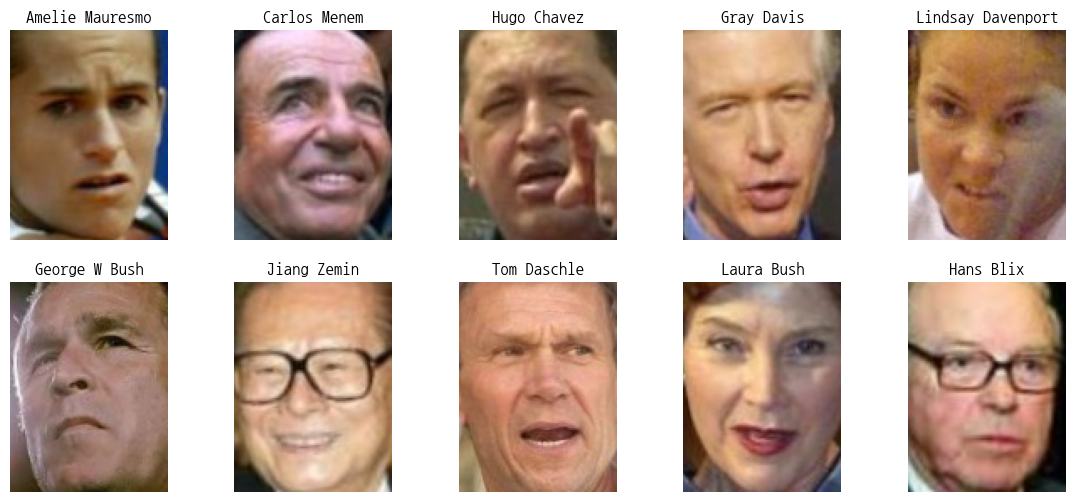

In [5]:
plt.figure(figsize=[14, 6])
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # imshow() 메소드로 컬러 이미지를 출력할 때 reshape() 메소드 실행 결과를 astype() 메소드로
    # 부호 없는 8비트 정수로 데이터 타입을 변경해야 한다.
    plt.imshow(x_train[i].reshape(h, w, 3).astype(np.uint8))
    plt.title(target_names[y_train[i]])
    plt.axis('off')
plt.show()

비음수 행렬 분해를 이용한 차원 축소

In [6]:
from sklearn.decomposition import NMF # 비음수 행렬 분해 알고리즘을 사용하기 위해 import 한다.
# n_components 속성으로 축소할 차원의 크기를 지정해서 비음수 행렬 분해 모델을 만든다.
# 35250 차원의 데이터를 10차원으로 축소한다.
nmf = NMF(n_components=10)

# nmf.fit(x_train, y_train) # 학습 데이터와 학습 데이터의 레이블로 비음수 행렬 분해 모델을 학습시킨다.
# x_train_nmf = nmf.transform(x_train) # 학습된 비음수 행렬 분해 모델에 학습 데이터를 적용시킨다.
x_train_nmf = nmf.fit_transform(x_train, y_train) # 비음수 행렬 분해 모델을 학습하고 학습 데이터를 적용시킨다.
# 학습은 학습 데이터로만 해야하고 테스트 데이터는 학습 데이터로 학습된 결과에 적용만 시킨다.
x_test_nmf = nmf.transform(x_test)

# 차원 축소 이전 데이터의 차원을 확인하면 차원 축소전의 피쳐 데이터는 13차원의 데이터 133개로 구성되어 있음을
# 알 수 있고 주성분 분석을 이용해 차원 축소한 데이터는 2차원 데이터 133개로 구성되어 있음을 알 수 있다.
print(x_train_nmf.shape, x_test_nmf.shape)

(2101, 10) (701, 10)


In [7]:
# 비음수 행렬 분해 벡터 확인
print(nmf.components_.shape)
print(nmf.components_)

(10, 35250)
[[ 1.0898719   0.07637401  0.         ...  0.          0.
   0.        ]
 [ 5.2715564   5.065902    4.5122166  ...  0.          0.
   0.        ]
 [ 2.3034227   2.5741348   2.3843894  ...  0.6096219   0.617341
   0.7365444 ]
 ...
 [10.87068     9.164184    6.5729923  ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  5.7565928   4.2319436
   3.3538609 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


비음수 행렬 분해 후 차원 축소된 컬러 이미지 시각화

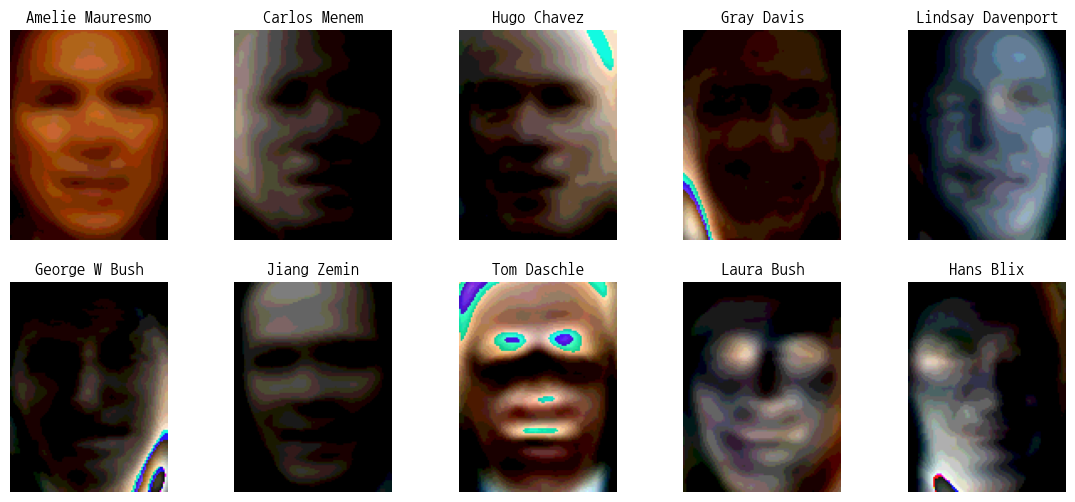

In [8]:
plt.figure(figsize=[14, 6])
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow((nmf.components_[i].astype(np.uint8) * 25).reshape(h, w, 3))
    plt.title(target_names[y_train[i]])
    plt.axis('off')
plt.show()

흑백 이미지로 읽기

In [9]:
# 사이킷런이 제공하는 흑백 얼굴 이미지 살펴보기
raw_data = datasets.fetch_lfw_people(min_faces_per_person=20, resize=1.0, color=False)
# 흑백 이미지는 크레이스케일로 0에서 255 사이의 단일 채널이므로 채널의 개수가 리턴되지 않는다.
n_samples, h, w = raw_data.images.shape
print('읽어온 전체 얼굴 개수: {}, 세로 크기: {}, 가로 크기: {}'.format(n_samples, h, w))

# raw_data.data: 2차원 얼굴 이미지 데이터 행렬을 늘어뜨려 1차원으로 나타낸 데이터
xData = raw_data.data # 피쳐 데이터(얼굴 이미지)를 저장한다.
n, p = xData.shape
# n이 3023인 이유는 min_faces_per_person 속성으로 지정한 조건을 만족하는 이미지의 개수가 3023개 이기
# 때문이고 p가 11750인 이유는 기존 125 * 94 행렬을 1차원으로 늘어뜨리면 11750이기 때문이다.
print('n: {}, p: {}'.format(n, p))

yData = raw_data.target # 피쳐 데이터(얼굴 이미지)에 따른 레이블을 저장한다.
target_names = raw_data.target_names # 피쳐 데이터(얼굴 이미지)에 따른 사람 이름을 저장한다.
print('{}개의 얼굴 이미지를 구성하는 인물의 수는 {}명 이다.'.format(n, target_names.shape[0]))

읽어온 전체 얼굴 개수: 2802, 세로 크기: 125, 가로 크기: 94
n: 2802, p: 11750
2802개의 얼굴 이미지를 구성하는 인물의 수는 54명 이다.


In [10]:
# 학습 데이터와 테스트 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(xData, yData, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(2101, 11750) (701, 11750) (2101,) (701,)


비음수 행렬 분해 전 오리지널 흑백 이미지 시각화

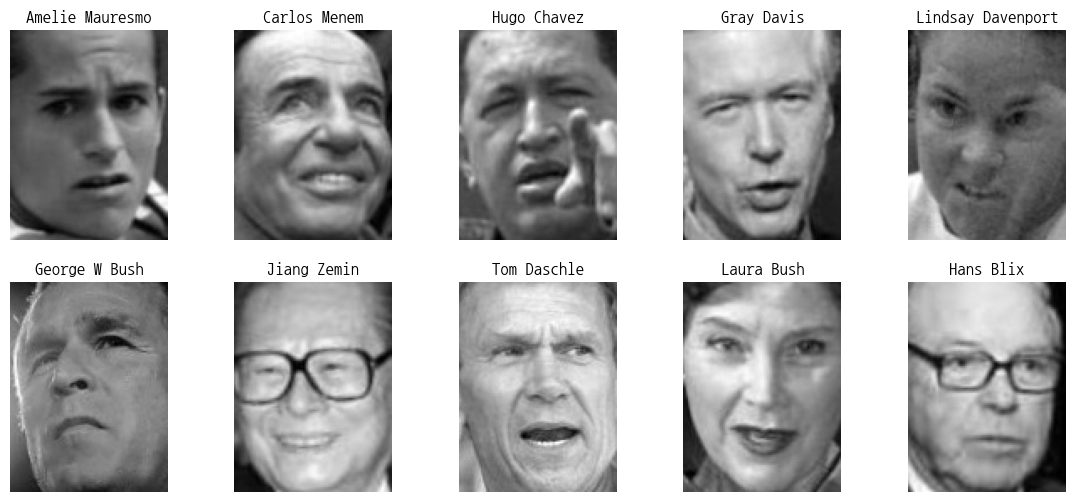

In [11]:
plt.figure(figsize=[14, 6])
plt.gray()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(h, w))
    plt.title(target_names[y_train[i]])
    plt.axis('off')
plt.show()

비음수 행렬 분해를 이용한 차원 축소

In [12]:
nmf = NMF(n_components=10) # 11750 차원의 데이터를 10차원으로 축소한다.
x_train_nmf = nmf.fit_transform(x_train, y_train)
x_test_nmf = nmf.transform(x_test)
print(x_train_nmf.shape, x_test_nmf.shape)

(2101, 10) (701, 10)


In [13]:
# 비음수 행렬 분해 벡터 확인
print(nmf.components_.shape)
print(nmf.components_)

(10, 11750)
[[ 0.          0.          0.         ...  0.5602838   0.66684884
   0.6801684 ]
 [ 0.          0.          0.         ...  0.23221198  0.07991387
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [13.775491   14.460539   14.827334   ...  2.10594     1.6948184
   1.576888  ]
 [18.078941   18.15571    18.028006   ...  0.          0.
   0.        ]]


비음수 행렬 분해 후 차원 축소된 흑백 이미지 시각화

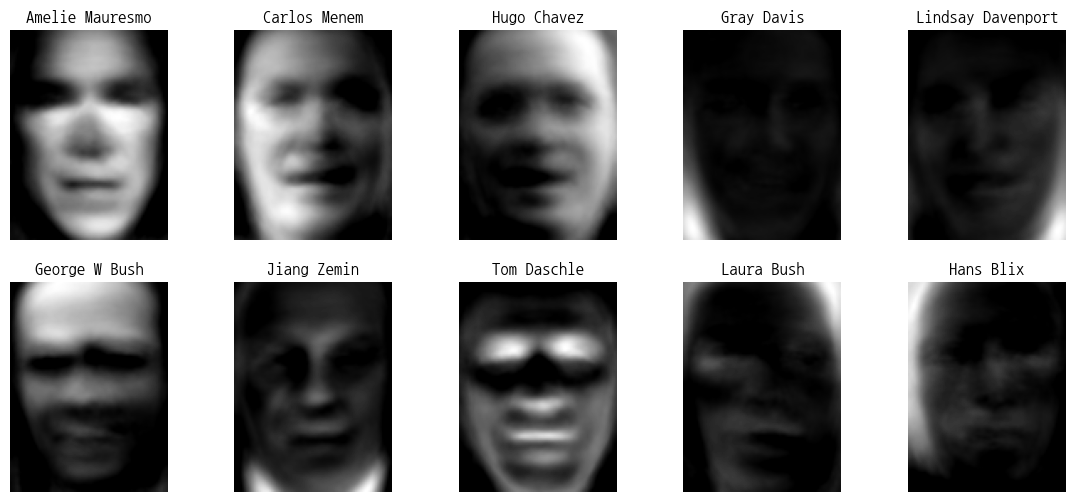

In [14]:
plt.figure(figsize=[14, 6])
plt.gray()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(nmf.components_[i].reshape(h, w))
    plt.title(target_names[y_train[i]])
    plt.axis('off')
plt.show()